In [ ]:
#| eval: false
! [ -e /content ] && pip install -Uqq xcube # upgrade xcube on colab

In [ ]:
from fastai.text.all import *
from xcube.text.all import *
from fastai.metrics import accuracy # there's an 'accuracy' metric in xcube as well (Deb fix name conflict later)  

Make sure we have that "beast":

In [ ]:
ic(torch.cuda.get_device_name(default_device()));
test_eq(torch.cuda.get_device_name(0), torch.cuda.get_device_name(default_device()))
test_eq(default_device(), torch.device(0))
print(f"GPU memory = {torch.cuda.get_device_properties(default_device()).total_memory/1024**3}GB")

ic| torch.cuda.get_device_name(default_device()): 'Quadro RTX 8000'


GPU memory = 44.99969482421875GB


In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
source = untar_xxx(XURLs.MIMIC3)
source_l2r = untar_xxx(XURLs.MIMIC3_L2R)

Setting some environment variables:

In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Setting defaults for pandas and matplotlib:

In [ ]:
# Set the default figure size
plt.rcParams["figure.figsize"] = (8, 4)

Altering some default jupyter settings:

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last" # "all"

# Training an XML Text Classifier

## `DataLoaders` for the Language Model

To be able to use Transfer Learning, first we need to fine-tune our Language Model (which we pretrained on Wikipedia) on the corpus of Wiki-500k (the one we downloaded). Here we will build the `DataLoaders` object using fastai's `DataBlock` API:

In [ ]:
data = source/'mimic3-9k.csv'
!head -n 1 {data}

subject_id,hadm_id,text,labels,length,is_valid


In [ ]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
len(df)

52726

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

Let's take a look at the data:

In [ ]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


We will now create the `DataLoaders` using `DataBlock` API:

In [ ]:
dls_lm = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

For the backward LM:

In [ ]:
dls_lm_r = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True, backwards=True),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

Let's take a look at the batches:

In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos admission date discharge date date of birth sex m service cardiothoracic allergies percocet attending first name3 lf chief complaint recent onset angina and doe major surgical or invasive procedure redo coronary artery bypass graft saphavenous graft posterior descending artery saphavenous graft obtuse marginal saphavenous diagonal atrial septal defect closure biventricular lead placement history of present illness yo male with history of cad and prior cabg x4 in his angina has been relatively stable and resolves with rest he has,admission date discharge date date of birth sex m service cardiothoracic allergies percocet attending first name3 lf chief complaint recent onset angina and doe major surgical or invasive procedure redo coronary artery bypass graft saphavenous graft posterior descending artery saphavenous graft obtuse marginal saphavenous diagonal atrial septal defect closure biventricular lead placement history of present illness yo male with history of cad and prior cabg x4 in his angina has been relatively stable and resolves with rest he has had
1,lft s and re checking ekg tox screen was only pos for amphetamines past medical history depression no previous psychiatric admission pcp last name namepattern4 last name stitle prescribes paxil adhd social history lives with roommate in location un plays piano gives lessons sister died months ago from crack overdose no etoh or drug use family history bipolar disorder physical exam pe hr bp rr os sat on vent ac 500x18 peep fio2 genl intubated sedated heent pupils sluggish mm,s and re checking ekg tox screen was only pos for amphetamines past medical history depression no previous psychiatric admission pcp last name namepattern4 last name stitle prescribes paxil adhd social history lives with roommate in location un plays piano gives lessons sister died months ago from crack overdose no etoh or drug use family history bipolar disorder physical exam pe hr bp rr os sat on vent ac 500x18 peep fio2 genl intubated sedated heent pupils sluggish mm no


In [ ]:
dls_lm_r.show_batch(max_n=2)

,text,text_
0,number job job t d medquist36 md name8 by dictated number md d m md name8 md name6 inhalers atrovent inhalers albuterol d q o p atenolol d i t o p tabs two sinemet d i b o p effexor d i q o p mg baclofen d i t o p mg xanax until continued be to d i t o p mg flagyl until continued be to d q o p mg levofloxacin medications discharge hypertension s,job job t d medquist36 md name8 by dictated number md d m md name8 md name6 inhalers atrovent inhalers albuterol d q o p atenolol d i t o p tabs two sinemet d i b o p effexor d i q o p mg baclofen d i t o p mg xanax until continued be to d i t o p mg flagyl until continued be to d q o p mg levofloxacin medications discharge hypertension s parkinson
1,les bilateral in present edema trace cyanosis or clubbing no ext nabs distended non soft panus large abdomen obese abd appreciated g r m no rhythm regular tachycardic cor chest across papules crusted round chest wheezes expiratory and inspiratory with bilaterally sounds breath coarse lung jvp visualize not could supple thick and short neck membranes mucous moist bilaterally reactive and mm 2 pupils heent stimuli painful to responsive minimally sedated and intubated man obese morbidly gen peep 600x18 ac on,bilateral in present edema trace cyanosis or clubbing no ext nabs distended non soft panus large abdomen obese abd appreciated g r m no rhythm regular tachycardic cor chest across papules crusted round chest wheezes expiratory and inspiratory with bilaterally sounds breath coarse lung jvp visualize not could supple thick and short neck membranes mucous moist bilaterally reactive and mm 2 pupils heent stimuli painful to responsive minimally sedated and intubated man obese morbidly gen peep 600x18 ac on hr


The length of our vocabulary is:

In [ ]:
len(dls_lm.vocab)

57376

Let's take a look at some words of the vocab:

In [ ]:
print(coll_repr(L(dls_lm.vocab), 30))

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','and','to','of','was','with','a','on','in','for','mg','no','tablet','patient','is','he','at','blood','name','po','she'...]


Creating the `DataLaoders` takes some time, so smash that *save* button (also a good idea to save the `dls_lm.vocab` for later use) if you are working on your own dataset. In this case though `untar_xxx` has got it for you:

In [ ]:
print("\n".join(L(source.glob("**/*dls*lm*.pkl")).map(str))) # the ones with _r are for the reverse language model

/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_vocab_r.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_vocab.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_r.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_old.pkl


To load back the `dls_lm` later on:

In [ ]:
dls_lm = torch.load(source/'mimic3-9k_dls_lm.pkl')

In [ ]:
dls_lm_r = torch.load(source/'mimic3-9k_dls_lm_r.pkl')

## `Learner` for the Language Model Fine-Tuning:

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

And, one more for the reverse:

In [ ]:
learn_r = language_model_learner(
    dls_lm_r, AWD_LSTM, drop_mult=0.3, backwards=True,
    metrics=[accuracy, Perplexity()]).to_fp16()

Training a language model on the full datset takes a lot of time. So you can train one on a tiny dataset for illustration. Or you can skip the training and just load up the one that's pretrained and downloaded by `untar_xxx` and just do the validation.

Let's compute the learning rate using the `lr_find`:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [ ]:
learn.fit_one_cycle(1, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.646323,3.512013,0.382642,33.515659,2:27:57


It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process:

Since we have completed the initial training, we will now continue fine-tuning the model after unfreezing:

In [ ]:
learn.unfreeze()

and run `lr_find` again, because we now have more layers to train, and the last layers weight have already been trained for one epoch:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

Let's now traing with a suitable learning rate:

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-3, cbs=SaveModelCallback(fname='lm'))

Note: Make sure if you have trained the most recent language model `Learner` for more epochs (then you need to save that version)

Here you can load the pretrained language model which `untar_xxx` downloaded:

In [ ]:
learn = learn.load(source/'mimic3-9k_lm')

In [ ]:
learn_r = learn_r.load(source/'mimic3-9k_lm_r')

Let's validate the `Learner` to make sure we loaded the correct version:

In [ ]:
learn.validate()

(#3) [2.050518035888672,0.5703166723251343,7.771926403045654]

and the reverse...

In [ ]:
learn_r.validate()

(#3) [2.099604845046997,0.569995641708374,8.162943840026855]

### Saving the encoder of the Language Model

**Crucial:** Once we have trained our LM we will save all of our model except the final layer that converts activation to probabilities of picking each token in our vocabulary. The model not including the final layer has a sexy name - *encoder*. We will save it using `save_encoder` method of the `Learner`:

In [ ]:
# learn.save_encoder('lm_finetuned')
# learn_r.save_encoder('lm_finetuned_r')

This completes the second stage of the text classification process - fine-tuning the Language Model pretrained on Wikipedia corpus. We will now use it to fine-tune a text multi-label text classifier.

## `DataLoaders` for the Multi-Label Classifier (using fastai's Mid-Level Data API)

Fastai's midlevel data api is the swiss army knife of data preprocessing. Detailed tutorials can be found here [intermediate](https://docs.fast.ai/tutorial.pets.html), [advanced](https://docs.fast.ai/tutorial.siamese.html). We will use it here to create our dataloaders for the classifier. 

### Loading Raw Data

In [ ]:
data = source/'mimic3-9k.csv'
!head -n 1 {data}

subject_id,hadm_id,text,labels,length,is_valid


In [ ]:
# !shuf -n 200000 {data} > {data_sample} 

In [ ]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

In [ ]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


Sample a small fraction of the dataset to ensure quick iteration (Skip this if you want to do this on the full dataset)

In [ ]:
# df = df.sample(frac=0.3, random_state=89, ignore_index=True)
# df = df.sample(frac=0.025, random_state=89, ignore_index=True)
df = df.sample(frac=0.005, random_state=89, ignore_index=True)
len(df)

264

Let's now gather the labels from the 'labels' columns of the df:

In [ ]:
lbl_freqs = Counter()
for labels in df.labels: lbl_freqs.update(labels.split(';'))

The total number of labels are:

In [ ]:
len(lbl_freqs)

1271

Let's take a look at the most common labels:

In [ ]:
pd.DataFrame(lbl_freqs.most_common(20), columns=['label', 'frequency'])

,label,frequency
0,401.9,84
1,38.93,77
2,428.0,61
3,272.4,60
4,427.31,56
5,414.01,56
6,584.9,49
7,96.04,48
8,250.00,45
9,518.81,42


Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [ ]:
lbls = list(lbl_freqs.keys())

### Dataset Statistics (Optional) 
> Let's try to understand what captures the hardness of an xml dataset

#### Check #1: Number of instances (train/valid split)

In [ ]:
train, valid = df.index[~df['is_valid']], df.index[df['is_valid']]
len(train), len(valid)

(244, 20)

#### Check #2: Avg number of instances per label

In [ ]:
array(list(lbl_freqs.values())).mean()

3.341463414634146

#### Check #3: Plotting the label distribution

In [ ]:
lbl_count = []
for lbls in df.labels: lbl_count.append(len(lbls.split(',')))

In [ ]:
df_copy = df.copy()
df_copy['label_count'] = lbl_count

In [ ]:
df_copy.head(2)

,text,labels,is_valid,label_count
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3


The average number of labels per instance is:

In [ ]:
df_copy.label_count.mean()

5.385563363865518

/home/deb/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


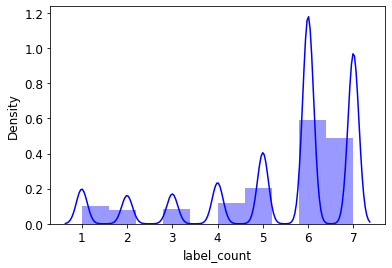

In [ ]:
import seaborn as sns
sns.distplot(df_copy.label_count, bins=10, color='b');

In [ ]:
lbls_sorted = sorted(lbl_freqs.items(), key=lambda item: item[1], reverse=True)

In [ ]:
lbls_sorted[:20]

[('455619', 2258),
 ('455662', 2176),
 ('547041', 2160),
 ('516790', 1214),
 ('455712', 1203),
 ('455620', 1133),
 ('632786', 1132),
 ('632789', 1132),
 ('632785', 1030),
 ('632788', 1030),
 ('492255', 938),
 ('455014', 872),
 ('670034', 850),
 ('427871', 815),
 ('599701', 803),
 ('308331', 801),
 ('581325', 801),
 ('649272', 799),
 ('455704', 762),
 ('666760', 733)]

In [ ]:
ranked_lbls = L(lbls_sorted).itemgot(0)
ranked_freqs = L(lbls_sorted).itemgot(1)
ranked_lbls, ranked_freqs

((#670091) ['455619','455662','547041','516790','455712','455620','632786','632789','632785','632788'...],
 (#670091) [2258,2176,2160,1214,1203,1133,1132,1132,1030,1030...])

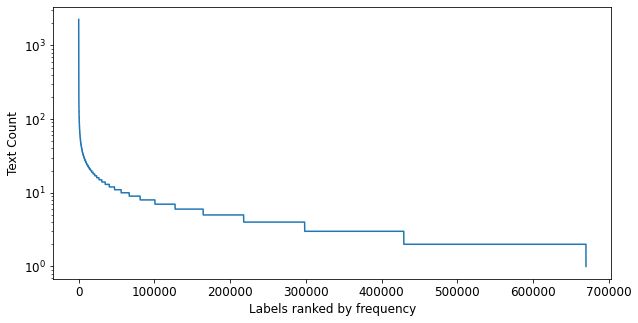

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ranked_freqs)
ax.set_xlabel('Labels ranked by frequency')
ax.set_ylabel('Text Count')
ax.set_yscale('log');

#### Check #4: Computing the min label freq for each text

In [ ]:
df_copy.head(10)

,text,labels,is_valid,label_count,min_code_freq,max_code_freq,90pct_code_freq
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6,2,29,25.5
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3,2,3,3.0
2,"MMF Industries 24-Key Portable Zippered Key Case (201502417) /SEP/ MMF Industries 24-Key Portable Zippered Key Case (201502417). The MMF Industries 201502417 24-Key Portable Zippered Key Case is an attractive burgundy-colored leather-like vinyl case with brass corners and looks like a portfolio. Its easy-slide zipper keeps keys enclosed, and a hook-and-loop fastener strips keep keys securely in place. Key tags are included.\tZippered key case offers a portable alternative to metal wall key cabinets. Included key tags are backed by hook-and-loop closures. Easy slide zipper keeps keys enclos...",393828,False,1,2,2,2.0
3,"Hoover the Fishing President /SEP/ Hoover the Fishing President. Hal Elliott Wert has spent years researching Herbert Hoover, Franklin Roosevelt, and Harry Truman. He holds a Ph.D. from the University of Kansas and currently teaches at the Kansas City Art Institute.","167614,223686",False,2,4,4,4.0
4,"GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs) /SEP/ GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs). GeoPuzzles are jigsaw puzzles that make learning world geography fun. The pieces of a GeoPuzzle are shaped like individual countries, so children learn as they put the puzzle together. Award-winning Geopuzzles help to build fine motor, cognitive, language, and problem-solving skills, and are a great introduction to world geography for children 4 and up. Designed by an art professor, jumbo sized and brightly colored GeoPuzzles are avail...","480528,480530,480532,485144,485146,598793",False,6,5,10,8.5
5,"Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing /SEP/ Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing. Pinpoint Oxford Cotton. Traditional Straight Collar, 1/4 Topstitched. Button Cuffs, 1/4 Topstitched. Embedded Collar Stay. Regular, Big and Tall. Top Center Placket. Split Yoke. Single Front Rounded Pocket. Machine Wash Or Dry Clean. Imported. * Big and Tall Sizes - addl $5.00","516790,567615,670034",False,3,256,1214,1141.2
6,"Darkest Fear : A Myron Bolitar Novel /SEP/ Darkest Fear : A Myron Bolitar Novel. Myron Bolitar's father's recent heart attack brings Myron smack into a midlife encounter with issues of adulthood and mortality. And if that's not enough to turn his life upside down, the reappearance of his first serious girlfriend is. The basketball star turned sports agent, who does a little detecting when business is slow, is saddened by the news that Emily Downing's 13-year-old son is dying and desperately needs a bone marrow transplant; even if she did leave him for the man who destroyed his basketball c...","50442,50516,50647,50672,50680,662538",False,6,2,3,2.5
7,"In Debt We Trust (2007) /SEP/ In Debt We Trust (2007). Just a few decades ago, owing more money than you had in your bank account was the exception, not the rule. Yet, in the last 10 years, consumer debt has doubled and,

In [ ]:
df_copy['min_code_freq'] = df_copy.apply(
    lambda row: min([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [ ]:
df_copy['max_code_freq'] = df_copy.apply(
    lambda row: max([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [ ]:
df_copy['90pct_code_freq'] = df_copy.apply(
    lambda row: np.percentile([lbl_freqs[lbl] for lbl in row.labels.split(',')], 90), axis=1)

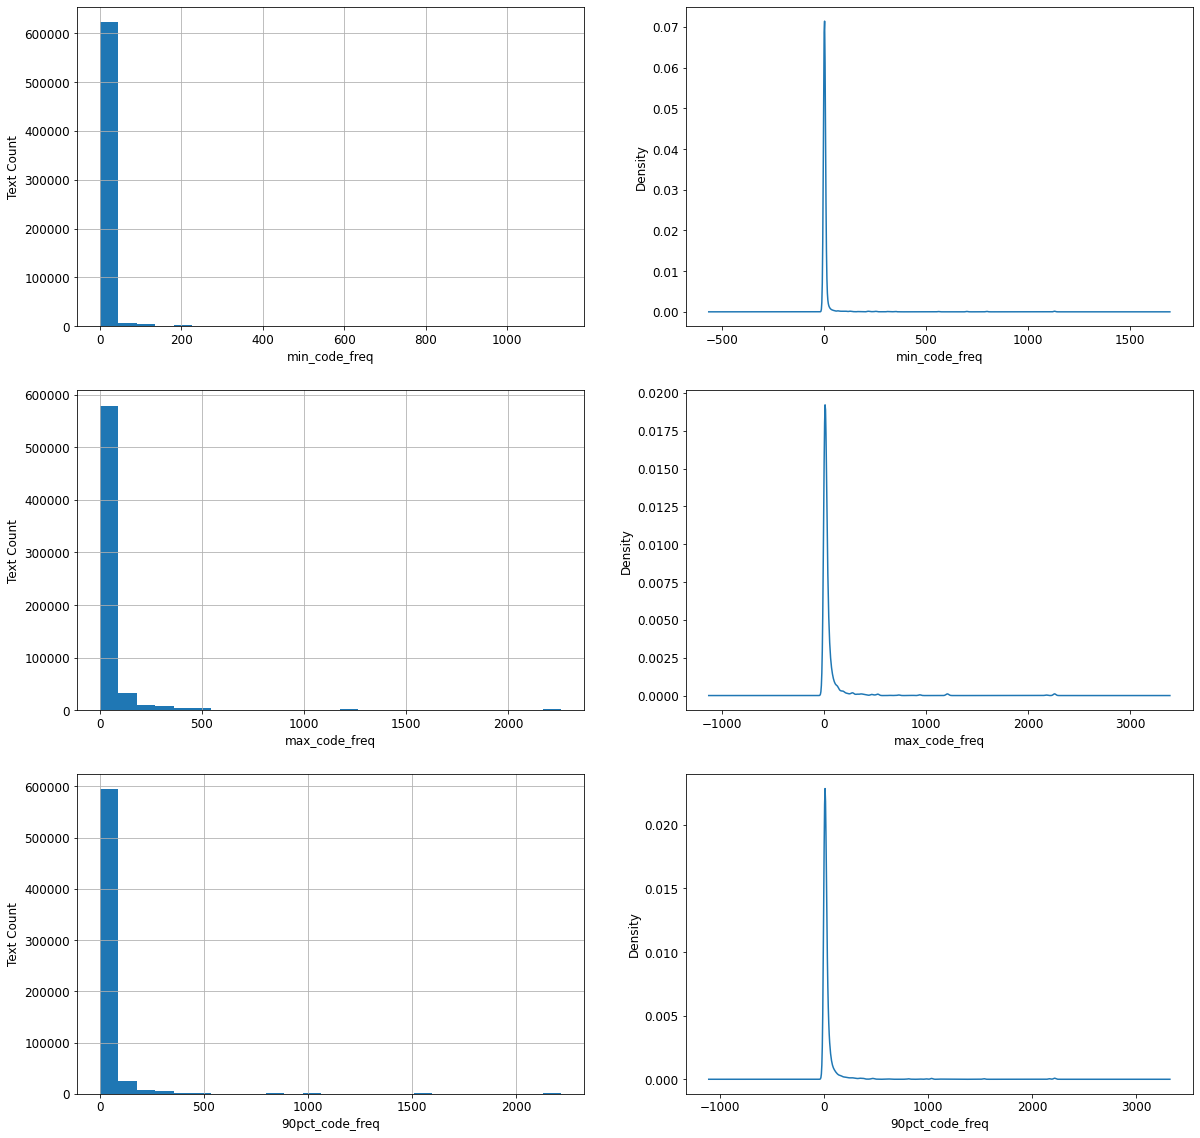

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for freq, axis in zip(['min_code_freq', 'max_code_freq', '90pct_code_freq'], axes):
    df_copy[freq].hist(ax=axis[0], bins=25)
    axis[0].set_xlabel(freq)
    axis[0].set_ylabel('Text Count')
    df_copy[freq].plot.density(ax=axis[1])
    axis[1].set_xlabel(freq)
    

In [ ]:
min_code_freqs = Counter(df_copy['min_code_freq'])
max_code_freqs = Counter(df_copy['max_code_freq'])
nintypct_code_freqs = Counter(df_copy['90pct_code_freq'])

In [ ]:
total_notes = L(min_code_freqs.values()).sum()
total_notes

643474

In [ ]:
for kmin in min_code_freqs:
    min_code_freqs[kmin] = (min_code_freqs[kmin]/total_notes) * 100
    
for kmax in max_code_freqs:
    max_code_freqs[kmax] = (max_code_freqs[kmax]/total_notes) * 100
    
for k90pct in nintypct_code_freqs:
    nintypct_code_freqs[k90pct] = (nintypct_code_freqs[k90pct]/total_notes) * 100

In [ ]:
min_code_freqs = dict(sorted(min_code_freqs.items(), key=lambda item: item[0]))
max_code_freqs = dict(sorted(max_code_freqs.items(), key=lambda item: item[0]))
nintypct_code_freqs = dict(sorted(nintypct_code_freqs.items(), key=lambda item: item[0]))

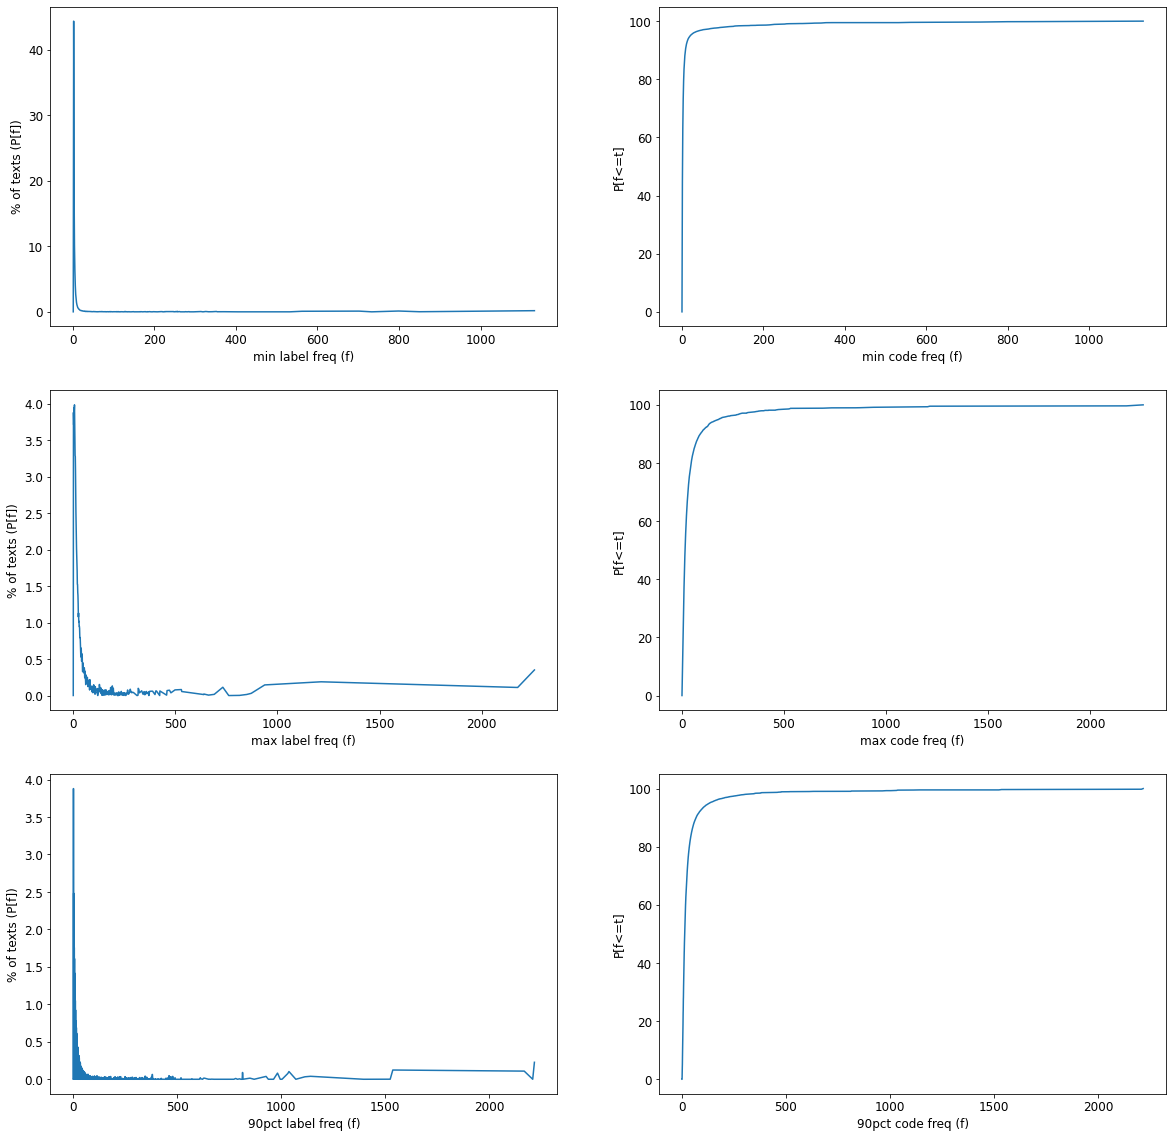

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for axis, freq_dict, label in zip(axes, (min_code_freqs, max_code_freqs, nintypct_code_freqs), ('min', 'max', '90pct')):
    axis[0].plot(freq_dict.keys(), freq_dict.values())
    axis[0].set_xlabel(f"{label} label freq (f)")
    axis[0].set_ylabel("% of texts (P[f])");
    
    axis[1].plot(freq_dict.keys(), np.cumsum(list(freq_dict.values())))
    axis[1].set_xlabel(f"{label} code freq (f)")
    axis[1].set_ylabel("P[f<=t]");

### Steps for creating the classifier `DataLoaders` using fastai's `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid

Let's check the train/valid split

In [ ]:
splits = [train, valid] = splitter(df)
L(splits[0]), L(splits[1])

((#244) [0,1,2,3,4,5,6,7,8,9...],
 (#20) [26,44,60,77,82,108,115,124,154,159...])

#### 2. Making the `Datasets` object:

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use. So we need to pass the `lm_vocab` to the `Numericalize` transform:

So let's load the vocab of the language model:

In [ ]:
lm_vocab = torch.load(source/'mimic3-9k_dls_lm_vocab.pkl')
lm_vocab_r = torch.load(source/'mimic3-9k_dls_lm_vocab_r.pkl')

In [ ]:
all_equal(lm_vocab, lm_vocab_r)
L(lm_vocab)

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...]

In [ ]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]
x_tfms_r = [Tokenizer.from_df('text', ), attrgetter("text"), Numericalize(vocab=lm_vocab), reverse_text]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]
tfms_r = [x_tfms_r, y_tfms]

In [ ]:
%%time
dsets = Datasets(df, tfms, splits=splits)

CPU times: user 73.8 ms, sys: 326 ms, total: 400 ms
Wall time: 865 ms


In [ ]:
%%time
dsets_r = Datasets(df, tfms_r, splits=splits)

CPU times: user 99.4 ms, sys: 137 ms, total: 236 ms
Wall time: 917 ms


Let's now check if our `Datasets` got created alright:

In [ ]:
len(dsets.train), len(dsets.valid)

(244, 20)

Let's check a random data point:

In [ ]:
idx = random.randint(0, len(dsets))
x = dsets.train[idx]
assert isinstance(x, tuple) # tuple if independent and dependent variable
x_r = dsets_r.train[idx]

In [ ]:
dsets.decode(x)

('xxbos admission date discharge date date of birth sex m service medicine allergies accupril naprosyn quinapril attending last name namepattern4 chief complaint hematemesis major surgical or invasive procedure egd history of present illness mr name14 stitle is a 57 m with a pmh of advanced metastatic pancreatic cancer s p gastric and biliary bypass chemo xrt and s p recent palliative small bowel bypass procedure for an sbo in this morning the patient reports sudden vomiting of 500cc of bright red blood with some dark clot about an hour after waking up he denies having had nausea abdominal pain lightheadness syncope shortness or breath or chest pain he was taken to hospital6 where he had a hematocrit of which is his baseline he recieved two liters of ns one unit of prbcs iv pantoprazole and was transferred to hospital1 in the ed his presenting vitals were bp hr rr o2sat ra he refused an ngt both gi and surgery were made aware of his admission one peripheral iv was placed in addition to

In [ ]:
dsets.show(x)

xxbos admission date discharge date date of birth sex m service medicine allergies accupril naprosyn quinapril attending last name namepattern4 chief complaint hematemesis major surgical or invasive procedure egd history of present illness mr name14 stitle is a 57 m with a pmh of advanced metastatic pancreatic cancer s p gastric and biliary bypass chemo xrt and s p recent palliative small bowel bypass procedure for an sbo in this morning the patient reports sudden vomiting of 500cc of bright red blood with some dark clot about an hour after waking up he denies having had nausea abdominal pain lightheadness syncope shortness or breath or chest pain he was taken to hospital6 where he had a hematocrit of which is his baseline he recieved two liters of ns one unit of prbcs iv pantoprazole and was transferred to hospital1 in the ed his presenting vitals were bp hr rr o2sat ra he refused an ngt both gi and surgery were made aware of his admission one peripheral iv was placed in addition to h

In [ ]:
assert isinstance(dsets.tfms[0], Pipeline) # `Pipeline` of the `x_tfms`
assert isinstance(dsets.tfms[0][0], Tokenizer)
assert isinstance(dsets.tfms[0][1], Transform)
assert isinstance(dsets.tfms[0][2], Numericalize)

If we just want to decode the one-hot encoded dependent variable:

In [ ]:
_ind, _dep = x
_lbl = dsets.tfms[1].decode(_dep)
test_eq(_lbl, array(lbls)[_dep.nonzero().flatten().int().numpy()])

Let's extract the `MultiCategorize` transform applied by `dsets` on the dependent variable so that we can apply it ourselves:

In [ ]:
tfm_cat = dsets.tfms[1][1]
test_eq(str(tfm_cat.__class__), "<class 'fastai.data.transforms.MultiCategorize'>")

`vocab` attribute of the `MultiCategorize` transform stores the category vocabulary. If it was specified from outside (in this case it was) then the `MultiCategorize` transform will not sort the vocabulary otherwise it will.

In [ ]:
test_eq(lbls, tfm_cat.vocab)
test_ne(lbls, sorted(tfm_cat.vocab))

In [ ]:
test_eq(str(_lbl.__class__), "<class 'fastai.data.transforms.MultiCategory'>")
test_eq(tfm_cat(_lbl), TensorMultiCategory([lbls.index(o) for o in _lbl]))
test_eq(tfm_cat.decode(tfm_cat(_lbl)), _lbl)

Let's check the reverse:

In [ ]:
# dsets_r.decode(x_r)

In [ ]:
# dsets_r.show(x_r)

Looks pretty good!

#### 3. Making the `DataLoaders` object:

We need to pick the sequence length and the batch size (you might have to adjust this depending on you GPU size)

In [ ]:
bs, sl = 16, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [ ]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [ ]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                             dl_type=dl_type,
                             before_batch=pad_input_chunk)

For the reverse:

In [ ]:
dls_clas_r = dsets_r.dataloaders(bs=bs, seq_len=sl,
                                 dl_type=dl_type,
                                 before_batch=pad_input_chunk)

Creating the `DataLoaders` object takes considerable amount of time, so do save it when working on your dataset. In this though, (as always) `untar_xxx` downloaded it for you:

In [ ]:
!tree -shLD 1 {source} -P *clas*
# or using glob
# L(source.glob("**/*clas*"))

/home/deb/.xcube/data/mimic3
├── [192M May  1  2022]  mimic3-9k_clas.pth
├── [192M May  1  2022]  mimic3-9k_clas2.pth
├── [1.6G Feb 20 15:55]  mimic3-9k_dls_clas.pkl
└── [1.6G Apr 22  2022]  mimic3-9k_dls_clas_old.pkl

0 directories, 4 files


Aside: Some handy linux find tricks:
1. https://stackoverflow.com/questions/18312935/find-file-in-linux-then-report-the-size-of-file-searched
2. https://stackoverflow.com/questions/4210042/how-to-exclude-a-directory-in-find-command

In [ ]:
# !find -path ./models -prune -o -type f -name "*caml*" -exec du -sh {} \;
# !find -not -path "./data/*" -type f -name "*caml*" -exec du -sh {} \;
# !find {path_data} -type f -name "*caml*" | xargs du -sh

If you want to load the dls for the full dataset:

In [ ]:
%%time
dls_clas = torch.load(source/'mimic3-9k_dls_clas.pkl')

CPU times: user 13.1 s, sys: 3.16 s, total: 16.2 s
Wall time: 16.6 s


Let's take a look at the data:

In [ ]:
# dls_clas.show_batch(max_n=3)

In [ ]:
# dls_clas_r.show_batch(max_n=3)

#### 4. (Optional) Making the `DataLoaders` using fastai's `DataBlock` API:

It's worth mentioning here that all the steps we performed to create the `DataLoaders` can be packaged together using fastai's `DataBlock` API. 

In [ ]:
dblock = DataBlock(
        blocks = (TextBlock.from_df('text', seq_len=sl, vocab=lm_vocab), MultiCategoryBlock(vocab=lbls)),
        get_x = ColReader('text'),
        get_y = ColReader('labels', label_delim=';'),
        splitter = splitter,
        dl_type = dl_type,
)

In [ ]:
dls_clas = dblock.dataloaders(df, bs=bs, before_batch=pad_input_chunk)

In [ ]:
dls_clas.show_batch(max_n=5)

## `Learner` for Multi-Label Classifier Fine-Tuning 

In [ ]:
# set_seed(897997989, reproducible=True)
# set_seed(67, reproducible=True)
set_seed(1, reproducible=True)

This is where we have `dls_clas`(for the full dataset) we made in the previous section:

In [ ]:
!tree -shL 1 {source} -P "*clas*"
# or using glob
# L(source.glob("**/*clas*"))

/home/deb/.xcube/data/mimic3
├── [192M]  mimic3-9k_clas.pth
├── [192M]  mimic3-9k_clas2.pth
├── [758K]  mimic3-9k_clas_full_vocab.pkl
├── [1.6G]  mimic3-9k_dls_clas.pkl
└── [1.6G]  mimic3-9k_dls_clas_old.pkl

0 directories, 5 files


And this is where we have the finetuned language model:

In [ ]:
!tree -shDL 1 {source} -P '*fine*'

/home/deb/.xcube/data/mimic3
├── [165M Apr 30  2022]  mimic3-9k_lm_finetuned.pth
└── [165M May  7  2022]  mimic3-9k_lm_finetuned_r.pth

0 directories, 2 files


Next we'll create a tmp directory to store results. In order for our learner to have access to the finetuned language model we need to symlink to it.

In [ ]:
#| eval: false
tmp = Path.cwd()/'tmp/models'
tmp.mkdir(exist_ok=True, parents=True)
tmp = tmp.parent
# (tmp/'models'/'mimic3-9k_lm_finetuned.pth').symlink_to(source/'mimic3-9k_lm_finetuned.pth') # run this just once
# (tmp/'models'/'mimic3-9k_lm_finetuned_r.pth').symlink_to(source/'mimic3-9k_lm_finetuned_r.pth') # run this just once
# (tmp/'models'/'mimic3-9k_tok_lbl_info.pkl').symlink_to(join_path_file('mimic3-9k_tok_lbl_info', source_l2r, ext='.pkl')) #run this just once
# list_files(tmp)
!tree -shD {tmp}

/home/deb/xcube/nbs/tmp
├── [ 23G Feb 21 13:27]  dls_full.pkl
├── [1.7M Feb 10 16:40]  dls_tiny.pkl
├── [152M Mar  8 00:28]  lin_lambdarank_full.pth
├── [1.0M Mar  7 16:52]  lin_lambdarank_tiny.pth
├── [ 10M Feb 20 16:22]  mimic3-9k_dls_clas_tiny.pkl
├── [ 10M Mar 19 19:16]  mimic3-9k_dls_clas_tiny_r.pkl
├── [4.0K Mar 29 17:36]  models
│   ├── [247M Mar 25 16:46]  mimic3-9k_clas_full.pth
│   ├── [758K Mar 25 16:46]  mimic3-9k_clas_full_vocab.pkl
│   ├── [277M Mar 29 15:19]  mimic3-9k_clas_tiny.pth
│   ├── [506M Mar 23 18:52]  mimic3-9k_clas_tiny_r.pth
│   ├── [635K Mar 23 18:52]  mimic3-9k_clas_tiny_r_vocab.pkl
│   ├── [635K Mar 29 15:19]  mimic3-9k_clas_tiny_vocab.pkl
│   ├── [  55 Mar  8 16:09]  mimic3-9k_lm_finetuned.pth -> /home/deb/.xcube/data/mimic3/mimic3-9k_lm_finetuned.pth
│   ├── [  57 Mar 19 19:27]  mimic3-9k_lm_finetuned_r.pth -> /home/deb/.xcube/data/mimic3/mimic3-9k_lm_finetuned_r.pth
│   └── [  59 Mar 29 17:36]  mimic3-9k_tok_lbl_info.pkl -> /home/deb/.xcube/data/mimic3_

Let's now get the dataloaders for the classifier. We'll also save classifier with `fname`.

In [ ]:
fname = 'mimic3-9k_clas_tiny'
dls_clas = torch.load(tmp/'mimic3-9k_dls_clas_tiny.pkl')
# dls_clas_r = torch.load(tmp/'mimic3-9k_dls_clas_tiny_r.pkl')
# dls_clas.show_batch(max_n=5)

Or if you want to load the one for the full dataset:

In [ ]:
fname = 'mimic3-9k_clas_full'
dls_clas = torch.load(source/'mimic3-9k_dls_clas.pkl')
# dls_clas_r = torch.load(source/'mimic3-9k_dls_clas_r.pkl')
# dls_clas.show_batch(max_n=5)

Let's create the saving callback upfront:

In [ ]:
fname_r = fname+'_r'
cbs=SaveModelCallback(monitor='precision_at_k', fname=fname, with_opt=True, reset_on_fit=True)
cbs_r=SaveModelCallback(monitor='precision_at_k', fname=fname_r, with_opt=True, reset_on_fit=True)

When the target is 1 we want the input to be close to 1 to incur low loss. So when the target is 1 we need to find out how much we need to boost the pred such that its sigmoid is close to 1.

In [ ]:
class LabelForcing(Callback):
    def __init__(self, end_epoch):
        self.end_epoch = end_epoch
    
    @torch.no_grad()
    def after_pred(self):
        if self.training and self.epoch <= self.end_epoch:
            pred, attn, wgts = self.learn.pred
            pos = Tensor(self.y) == 1
            pred[pos] += 3*pred.std()
            pred[~pos] -= 3*pred.std()
            attn[pos] += attn[pos].std(dim=-1).unsqueeze(-1)
            attn[~pos] -= attn[~pos].std(dim=-1).unsqueeze(-1)

In [ ]:
xb, yb = dls_clas.one_batch()
pred, attn, wgts = learn.model.to(0)(xb)
L(pred, yb, attn, wgts).map(Self.shape())
pos = Tensor(yb) == 1
before_pos, before_neg = attn[pos].sum(-1).mean(), attn[~pos].sum(-1).mean()
after_pos, after_neg = attn[pos].sum(-1).mean(), attn[~pos].sum(-1).mean()
assert before_pos < after_pos and before_neg > after_neg

In [ ]:
lf = LabelForcing(1) 
cbs = L( [cbs]+ [lf])
cbs

(#2) [SaveModelCallback,LabelForcing]

We will make the `TextLearner` (Here you can use `pretrained=Fasle` to save time beacuse we are anyway going to `load_encoder` later which will replace the encoder wgts with the ones we that we have in the fine-tuned LM):

In [ ]:
# %%debug
learn = xmltext_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=72*40, 
                                   metrics=partial(precision_at_k, k=15), path=tmp, cbs=cbs,
                                   pretrained=False,
                                   splitter=None).to_fp16()
# learn_r = xmltext_classifier_learner(dls_clas_r, AWD_LSTM, drop_mult=0.1, max_len=72*40, 
#                                    metrics=partial(precision_at_k, k=15), path=tmp, cbs=cbs_r,
#                                    pretrained=False,
#                                    splitter=None).to_fp16()  

In [ ]:
# for i,g in enumerate(awd_lstm_xclas_split(learn.model)):
    # print(f"group: {i}, {g=}")
    # print("****")

In [ ]:
#| hide
# learn.model[0].__class__??
# learn.model[1].__class__??
# learn.model[1].pay_attn.__class__??

The following line essentially captures the magic of [ULMFit's](https://arxiv.org/pdf/1801.06146.pdf) transfer learning:

In [ ]:
learn = learn.load_encoder('mimic3-9k_lm_finetuned')
# learn_r = learn_r.load_encoder('mimic3-9k_lm_finetuned_r')

In [ ]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
learn = learn.load_brain('mimic3-9k_tok_lbl_info')

do some tests


In [ ]:
learn.model[1].pay_attn

XMLAttention(
  (lbs): Embedding(1271, 400)
  (LinAttn): fastai.layers.Lambda(func=<xcube.layers._Pay_Attention object>)
)

## Dev (Ignore)

In [ ]:
tst_model = get_xmltext_classifier2(AWD_LSTM, 60000, 1271, seq_len=72, config=awd_lstm_clas_config, 
                               drop_mult=0.1, max_len=72*40).to(default_device())

In [ ]:
xb, yb = dls_clas.one_batch()

In [ ]:
L(xb, yb).map(lambda o: (o.shape, o.device))

(#2) [(torch.Size([16, 4555]), device(type='cuda', index=0)),(torch.Size([16, 1271]), device(type='cuda', index=0))]

In [ ]:
sent_enc = learn.model[0].to(default_device())
attn_clas = learn.model[1].to(default_device())

In [ ]:
preds_by_sent_enc, mask = sent_enc(xb)
preds_by_sent_enc.shape, mask.shape

(torch.Size([16, 2827, 400]), torch.Size([16, 2827]))

In [ ]:
o = tst_model(xb)

In [ ]:
o[0].shape

torch.Size([16, 1271])

In [ ]:
tst_model[1].hl.shape

torch.Size([16, 1271])

## Fine-Tuning the Classifier 

The last step (yes, the madness will end soon) is to train with:
- *discriminative learning rates*: define here
- *gradual unfreezing*: define here

as defined here in [ULMFit](https://arxiv.org/pdf/1801.06146.pdf)

If we are using the `LabelForcing` callback, then the loss will spike after certain number of epochs. So we need to remove this callback before doing `lr_find`. This is because `lr_find` aborts if things go south with regard to loss. 

lr_min=0.10568175315856934, lr_steep=0.00201372429728508, lr_valley=0.005248074419796467, lr_slide=2.6546056270599365


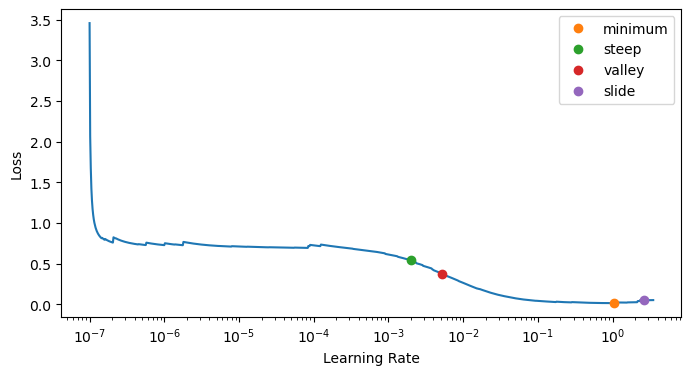

In [ ]:
lbl_fcr = None
with suppress(ValueError): lbl_fcr = learn.cbs[learn.cbs.map(type).index(LabelForcing)]
with learn.removed_cbs(lbl_fcr):
    lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), num_it=1000)
    print(f"{lr_min=}, {lr_steep=}, {lr_valley=}, {lr_slide=}")

In [ ]:
# learn.opt.hypers.map(lambda d: d['lr'])

In [ ]:
#full
learn.fit_one_cycle(2, lr_max=0.2, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.015781,0.016640,0.331771,18:08
1,0.012541,0.015442,0.394998,18:23


Better model found at epoch 0 with precision_at_k value: 0.33177145116646906.
Better model found at epoch 1 with precision_at_k value: 0.39499802293396613.


In [ ]:
learn = learn.load((learn.path/learn.model_dir)/fname)

In [ ]:
learn.fit_one_cycle(6, lr_max=0.14, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.321487,0.074264,0.253333,00:06
1,0.169174,0.075293,0.246667,00:06
2,0.115362,0.073120,0.256667,00:05
3,0.086118,0.072198,0.266667,00:05
4,0.066589,0.069950,0.323333,00:05
5,0.052745,0.069912,0.313333,00:05


Better model found at epoch 0 with precision_at_k value: 0.25333333333333335.
Better model found at epoch 2 with precision_at_k value: 0.2566666666666667.
Better model found at epoch 3 with precision_at_k value: 0.2666666666666667.
Better model found at epoch 4 with precision_at_k value: 0.3233333333333333.


In [ ]:
validate(learn)

best so far = 0.39499802293396613


[0.01544222142547369, 0.39499802293396613]
best so far = 0.39499802293396613


In [ ]:
learn.opt.hypers.map(lambda d: d['lr'])
# L(apply(d.get, ['wd', 'lr']))

(#5) [0.01852957908526126,0.01852957908526126,0.01852957908526126,0.01852957908526126,0.01852957908526126]

This was the result after just three epochs. Now let's unfreeze the last two layers and do discriminative training:  

Now we will pass -2 to `freeze_to` to freeze all except the last two parameter groups:

In [ ]:
learn.freeze_to(-2)
# learn.freeze_to(-4)

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.021990,0.071486,0.313333,00:07
1,0.021379,0.073118,0.323333,00:06
2,0.020406,0.074689,0.320000,00:06
3,0.019578,0.074937,0.323333,00:06
4,0.019001,0.074952,0.323333,00:06


Better model found at epoch 0 with precision_at_k value: 0.31333333333333335.
Better model found at epoch 1 with precision_at_k value: 0.32333333333333336.


In [ ]:
learn.opt.hypers.map(lambda d: d['lr'])
# L(apply(d.get, ['wd', 'lr']))

(#5) [0.0009202841157644292,0.0009202841157644292,0.0009202841157644292,0.0009202841157644292,0.0009202841157644292]

In [ ]:
validate(learn)

best so far = 0.34


[0.06955067813396454, 0.34]
best so far = 0.34


Now we will unfreeze a bit more, recompute learning rate and continue training:

In [ ]:
learn.freeze_to(-3)
# learn.freeze_to(-5)

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.019429,0.074671,0.316667,00:08
1,0.018433,0.078124,0.310000,00:08
2,0.017211,0.079145,0.310000,00:08
3,0.016078,0.080204,0.306667,00:08
4,0.015307,0.080494,0.306667,00:10


Better model found at epoch 0 with precision_at_k value: 0.3166666666666667.


In [ ]:
learn.opt.hypers.map(lambda d: d['lr'])
# L(apply(d.get, ['wd', 'lr']))

(#5) [0.0006998111963224469,0.0006998111963224469,0.0006998111963224469,0.0006998111963224469,0.0006998111963224469]

In [ ]:
validate(learn)

best so far = 0.23000000000000004


[0.13937118649482727, 0.23000000000000004]
best so far = 0.23000000000000004


Finally, we will unfreeze the whole model and perform training: (Caution: Check if you got enough memory left!)

In [ ]:
cudamem()

GPU: Quadro RTX 8000
You are using 10.4453125 GB
Total GPU memory = 44.99969482421875 GB


In [ ]:
learn.unfreeze()

At this point, it starts overfitting too soon so either progressively increase `bs` or increase `wd` or decrease `lr_max`. Another way would be to drop out label embeddings, but for this one needs to carefully adjust the dropout prob. Same concept regarding dropping out the seqs nh.

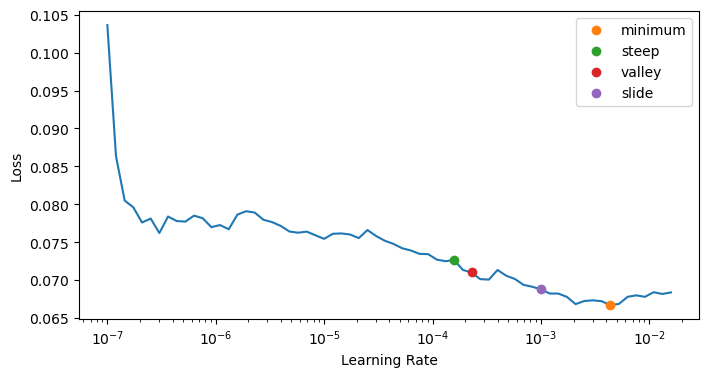

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum,steep,valley,slide), num_it=100)

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide

(0.00043651582673192023,
 0.00015848931798245758,
 0.0002290867705596611,
 0.0010000000474974513)

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-4, moms=(0.8,0.7,0.8), wd=0.2)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.000861,0.067473,0.330000,00:11
1,0.000840,0.067594,0.330000,00:10
2,0.000832,0.067833,0.333333,00:10
3,0.022438,0.067643,0.326667,00:10
4,0.034902,0.067802,0.326667,00:10
5,0.042870,0.067993,0.326667,00:09
6,0.048093,0.068144,0.326667,00:10
7,0.051539,0.068223,0.326667,00:10
8,0.053912,0.068255,0.326667,00:10
9,0.055520,0.068262,0.330000,00:10


Better model found at epoch 0 with precision_at_k value: 0.33.
Better model found at epoch 2 with precision_at_k value: 0.33333333333333337.


In [ ]:
validate(learn)

best so far = 0.29333333333333333


[0.07909457385540009, 0.29333333333333333]
best so far = 0.29333333333333333


## Fine-Tuning the Bwd Classifier 

In [ ]:
set_seed(1, reproducible=True)

(0.2754228591918945,
 0.033113110810518265,
 0.002511886414140463,
 0.033113110810518265)

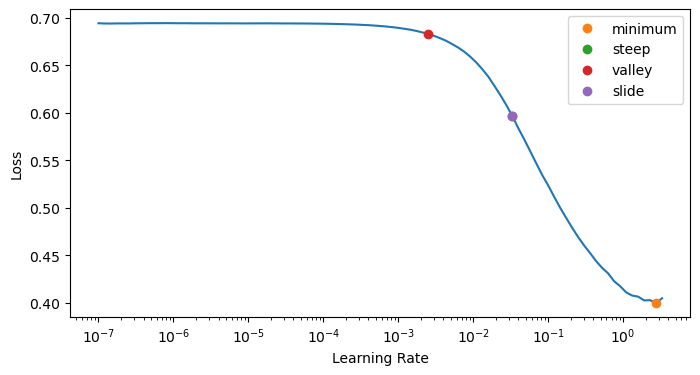

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn_r.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [ ]:
learn_r.fit_one_cycle(5, lr_max=0.14, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.327018,0.069560,0.256667,00:06
1,0.208054,0.071316,0.263333,00:05
2,0.160775,0.071520,0.276667,00:05
3,0.134363,0.071205,0.286667,00:06
4,0.116726,0.071068,0.290000,00:05


Better model found at epoch 0 with precision_at_k value: 0.2566666666666667.
Better model found at epoch 1 with precision_at_k value: 0.2633333333333333.
Better model found at epoch 2 with precision_at_k value: 0.27666666666666667.
Better model found at epoch 3 with precision_at_k value: 0.2866666666666667.
Better model found at epoch 4 with precision_at_k value: 0.29.


In [ ]:
validate(learn_r)

best so far = 0.3166666666666667


[0.06839973479509354, 0.3166666666666667]
best so far = 0.3166666666666667


This was the result after just three epochs. Now let's unfreeze the last two layers and do discriminative training:  

Now we will pass -2 to `freeze_to` to freeze all except the last two parameter groups:

In [ ]:
learn_r.freeze_to(-2)

In [ ]:
learn_r.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.077433,0.076003,0.276667,00:07
1,0.080553,0.078826,0.283333,00:06
2,0.080047,0.081196,0.283333,00:06
3,0.078719,0.081062,0.293333,00:06
4,0.077066,0.081063,0.293333,00:06


Better model found at epoch 0 with precision_at_k value: 0.2766666666666667.
Better model found at epoch 1 with precision_at_k value: 0.2833333333333333.
Better model found at epoch 3 with precision_at_k value: 0.29333333333333333.


In [ ]:
validate(learn_r)

best so far = 0.29000000000000004


[0.08007880300283432, 0.29000000000000004]
best so far = 0.29000000000000004


Now we will unfreeze a bit more, recompute learning rate and continue training:

In [ ]:
learn_r.freeze_to(-3)

In [ ]:
learn_r.fit_one_cycle(5, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.2)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.073836,0.083361,0.290000,00:09
1,0.073381,0.083838,0.280000,00:08
2,0.071263,0.088067,0.293333,00:08
3,0.068647,0.092060,0.290000,00:10
4,0.066179,0.091168,0.293333,00:08


Better model found at epoch 0 with precision_at_k value: 0.2899999999999999.
Better model found at epoch 2 with precision_at_k value: 0.29333333333333333.


In [ ]:
validate(learn_r)

best so far = 0.2966666666666667


[0.08150946348905563, 0.2966666666666667]
best so far = 0.2966666666666667


Finally, we will unfreeze the whole model and perform training: (Caution: Check if you got enough memory left!)

In [ ]:
cudamem()

GPU: Quadro RTX 8000
You are using 9.798828125 GB
Total GPU memory = 44.99969482421875 GB


In [ ]:
learn_r.unfreeze()

At this point, it starts overfitting too soon so either progressively increase `bs` or increase `wd` or decrease `lr_max`. Another way would be to drop out label embeddings, but for this one needs to carefully adjust the dropout prob. Same concept regarding dropping out the seqs nh.

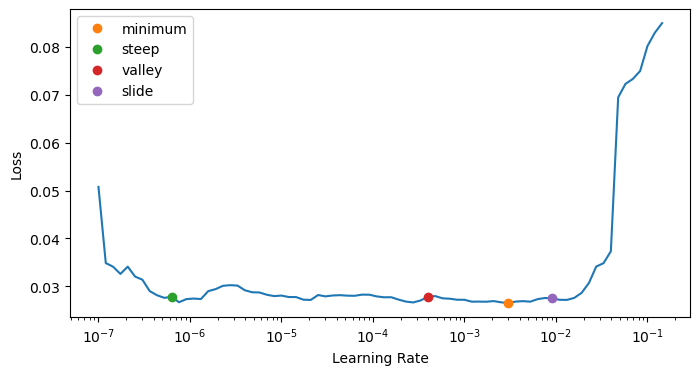

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn_r.lr_find(suggest_funcs=(minimum,steep,valley,slide), num_it=100)

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide

(0.0003019951749593019,
 6.309573450380412e-07,
 0.0003981071640737355,
 0.009120108559727669)

In [ ]:
learn_r.fit_one_cycle(10, lr_max=1e-4, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,precision_at_k,time
0,0.064373,0.087895,0.296667,00:11
1,0.064310,0.087949,0.296667,00:10
2,0.063739,0.089096,0.293333,00:10
3,0.062852,0.090236,0.293333,00:10
4,0.062443,0.091487,0.293333,00:10
5,0.062105,0.091792,0.290000,00:10
6,0.061126,0.091894,0.286667,00:10
7,0.060621,0.092186,0.283333,00:10
8,0.060148,0.092261,0.283333,00:10
9,0.059983,0.092269,0.283333,00:10


Better model found at epoch 0 with precision_at_k value: 0.29666666666666675.


In [ ]:
validate(learn_r)

best so far = 0.2866666666666667


[0.08382819592952728, 0.2866666666666667]
best so far = 0.2866666666666667


Ensemble of fwd+bwd:

In [ ]:
preds, targs = learn.get_preds()
preds_r, targs = learn_r.get_preds()
precision_at_k(preds+preds_r, targs)

0.31333333333333335

## Plotting the Label Embeddings

> To know if the model learnt embeddings that are meaningful

In [ ]:
lbs_emb = learn.model[-1].pay_attn.lbs.weight
X = to_np(lbs_emb)

Now let's do a PCA and t-SNE on the labels embedding. Before doing PCA though we need to standardize `X`:

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_stand = StandardScaler().fit_transform(X)

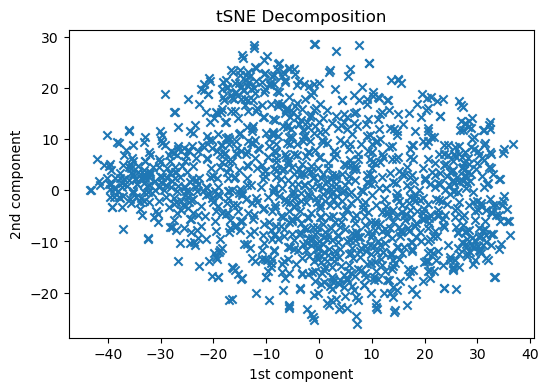

In [ ]:
X_reduced, _vars = plot_reduction(X, tSNE=True) 
# X_random, _vars_rnd = plot_reduction(np.random.normal(size=(X.shape[0], 400)), tSNE=True) # to compare with a random embeddings

In [ ]:
# print('\n'.join(L(source.glob('**/*desc*')).map(str)))
codes = load_pickle(source/'code_desc.pkl')
df_lbl = pd.DataFrame([(lbl, codes.get(lbl, "not found"), freq) for lbl, freq in lbl_freqs.items()], columns=['label', 'description', 'frequency'])
df_lbl = df_lbl.sort_values(by='frequency', ascending=False, ignore_index=True)
df_lbl.head()

,label,description,frequency
0,401.9,Unspecified essential hypertension,84
1,38.93,"Venous catheterization, not elsewhere classified",77
2,428.0,"Congestive heart failure, unspecified",61
3,272.4,Other and unspecified hyperlipidemia,60
4,427.31,Atrial fibrillation,56


Instead of doing a PCA on all the labels, let's do it on the `top` most frequent labels:

In [ ]:
top = 100
top_lbs = [k for k, v in lbl_freqs.most_common(top)]
tfm_cat = dls_clas.tfms[1][1]
top_lbs_emb = lbs_emb[tfm_cat(top_lbs)]
topX = to_np(top_lbs_emb)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
topX_tsne = TSNE(n_components=2, perplexity=40).fit_transform(topX)

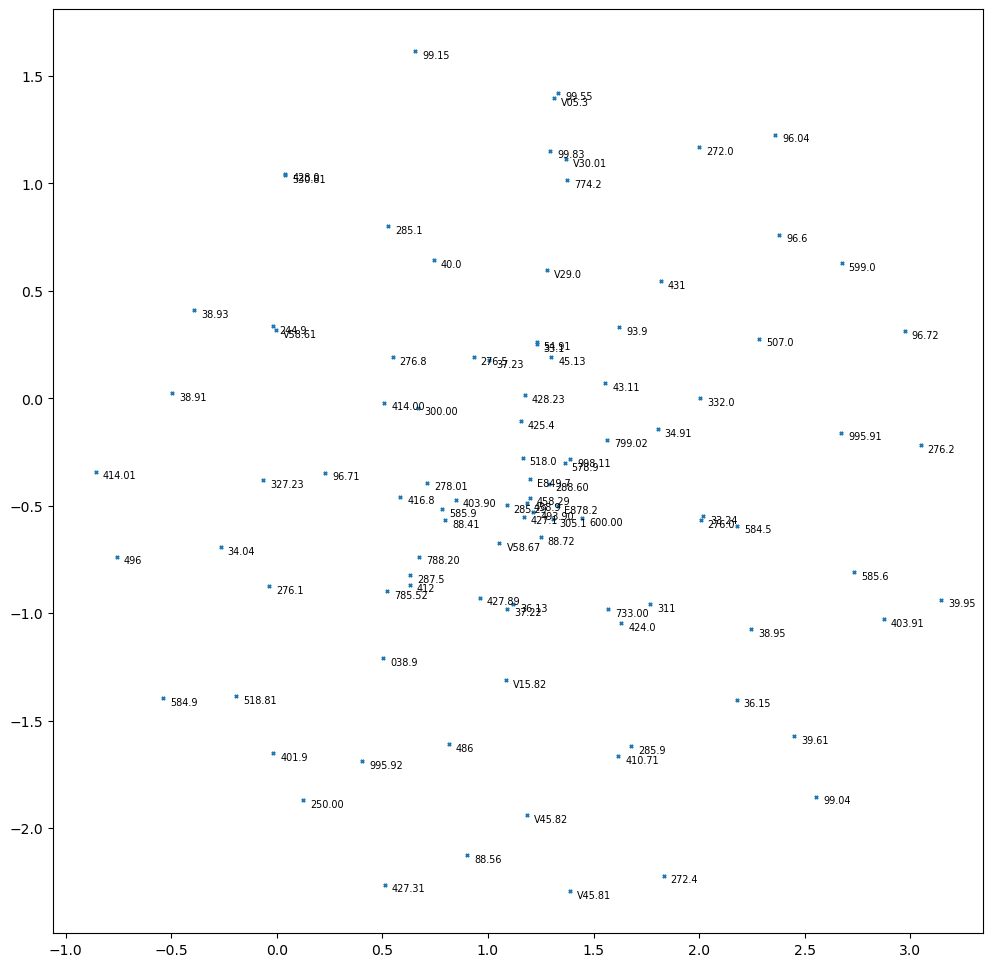

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(topX_tsne[:, 0], topX_tsne[:, 1], marker='x', s=5)
for lbl, x, y in zip(top_lbs, topX_tsne[:, 0], topX_tsne[:, 1]):
    plt.annotate(lbl,
                xy=(x,y),
                xytext=(5,-5),
                textcoords='offset points',
                size=7)
plt.show()

Take a look at some of the closely clustered labels to see if they have the same meaning. This will tell us if the model learned meaningful label embeddings:

In [ ]:
df_lbl[df_lbl.label.isin(['36.13', '995.91', '88.72', '37.22'])]

,label,description,frequency
48,88.72,Diagnostic ultrasound of heart,14
56,37.22,Left heart cardiac catheterization,13
64,995.91,Sepsis,11
70,36.13,(Aorto)coronary bypass of three coronary arteries,10


Looks like it did!